In [1]:
import qiskit
from qiskit import *
import qiskit.quantum_info as QI
import numpy as np
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, partial_trace, Statevector, DensityMatrix, entropy

from qiskit_aer import Aer
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import EstimatorV2 as Estimator

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

In [2]:
def rand_Cliff_circ(n_qbits, T, prob=0.5):
    tot_qbits = n_qbits+1
    qubits = QuantumRegister(n_qbits+1) # +1 for reference qubit
    cbits = ClassicalRegister(n_qbits*T)
    qc = qiskit.QuantumCircuit(qubits, cbits)

    # store whether there was a measurement or not
    meas_mask = np.empty((T, n_qbits), dtype=bool)
    meas_mask.fill(True)

    # Prepare Bell state with the middle qubit (n_qbits // 2) and the new qubit (last qubit)
    mid_qubit = n_qbits // 2
    ref_qubit = tot_qbits - 1

    # Prepare Bell-state with middle and reference qubit
    qc.h(mid_qubit)
    qc.cx(mid_qubit, ref_qubit)

    for t in range(T):
        if t%2 == 0:
            for qbit_idx in range(0, n_qbits, 2):
                if qbit_idx == 0:
                    qc.append(QI.random_clifford(2), [n_qbits-1, qbit_idx])
                elif qbit_idx != n_qbits-1:
                    qc.append(QI.random_clifford(2), [qbit_idx-1, qbit_idx])
        else:
            for qbit_idx in range(0, n_qbits, 2):
                qc.append(QI.random_clifford(2), [qbit_idx, qbit_idx+1])
        qc.barrier()
        
        for idx, qbit in enumerate(qc.qubits[:-1]):
            num = np.random.rand()
            if num >= prob:
                qc.measure(idx, t*n_qbits+idx)
                meas_mask[t, idx] = False
        qc.barrier()

    qc.save_statevector()

    return qc, meas_mask


def run_circuit_and_get_results(qc, nshots=100):
    # Simulate measurement results using Qasm simulator
    aer_simulator = Aer.get_backend('aer_simulator')
    transpiled_qc = transpile(qc, aer_simulator)
    result = aer_simulator.run(transpiled_qc, shots=1).result()
    
    # counts = result.get_counts()
    # final_state = result.get_statevector()

    # # Get the density matrix using the statevector simulator
    # state_simulator = Aer.get_backend('statevector_simulator')
    # transpiled_qc = transpile(qc, state_simulator)
    # state_result = state_simulator.run(transpiled_qc).result()
    # final_state = state_result.get_statevector()

    return result

def get_red_dens_mat(final_state, n_qbits):
    # Calculate the reduced density matrix of the last qubit (reference qubit)
    total_density_matrix = DensityMatrix(final_state)
    reduced_density_matrix = partial_trace(total_density_matrix, range(n_qbits))

    return reduced_density_matrix


def entanglement_entropy(reduced_density_matrix):
    # Get eigenvalues of the reduced density matrix
    eigvals, _ = np.linalg.eig(reduced_density_matrix)
    # Calculate the von Neumann entropy
    entropy = -np.sum(eigvals * np.log2(eigvals + 1e-12))  # Add small epsilon for numerical stability
    
    return entropy

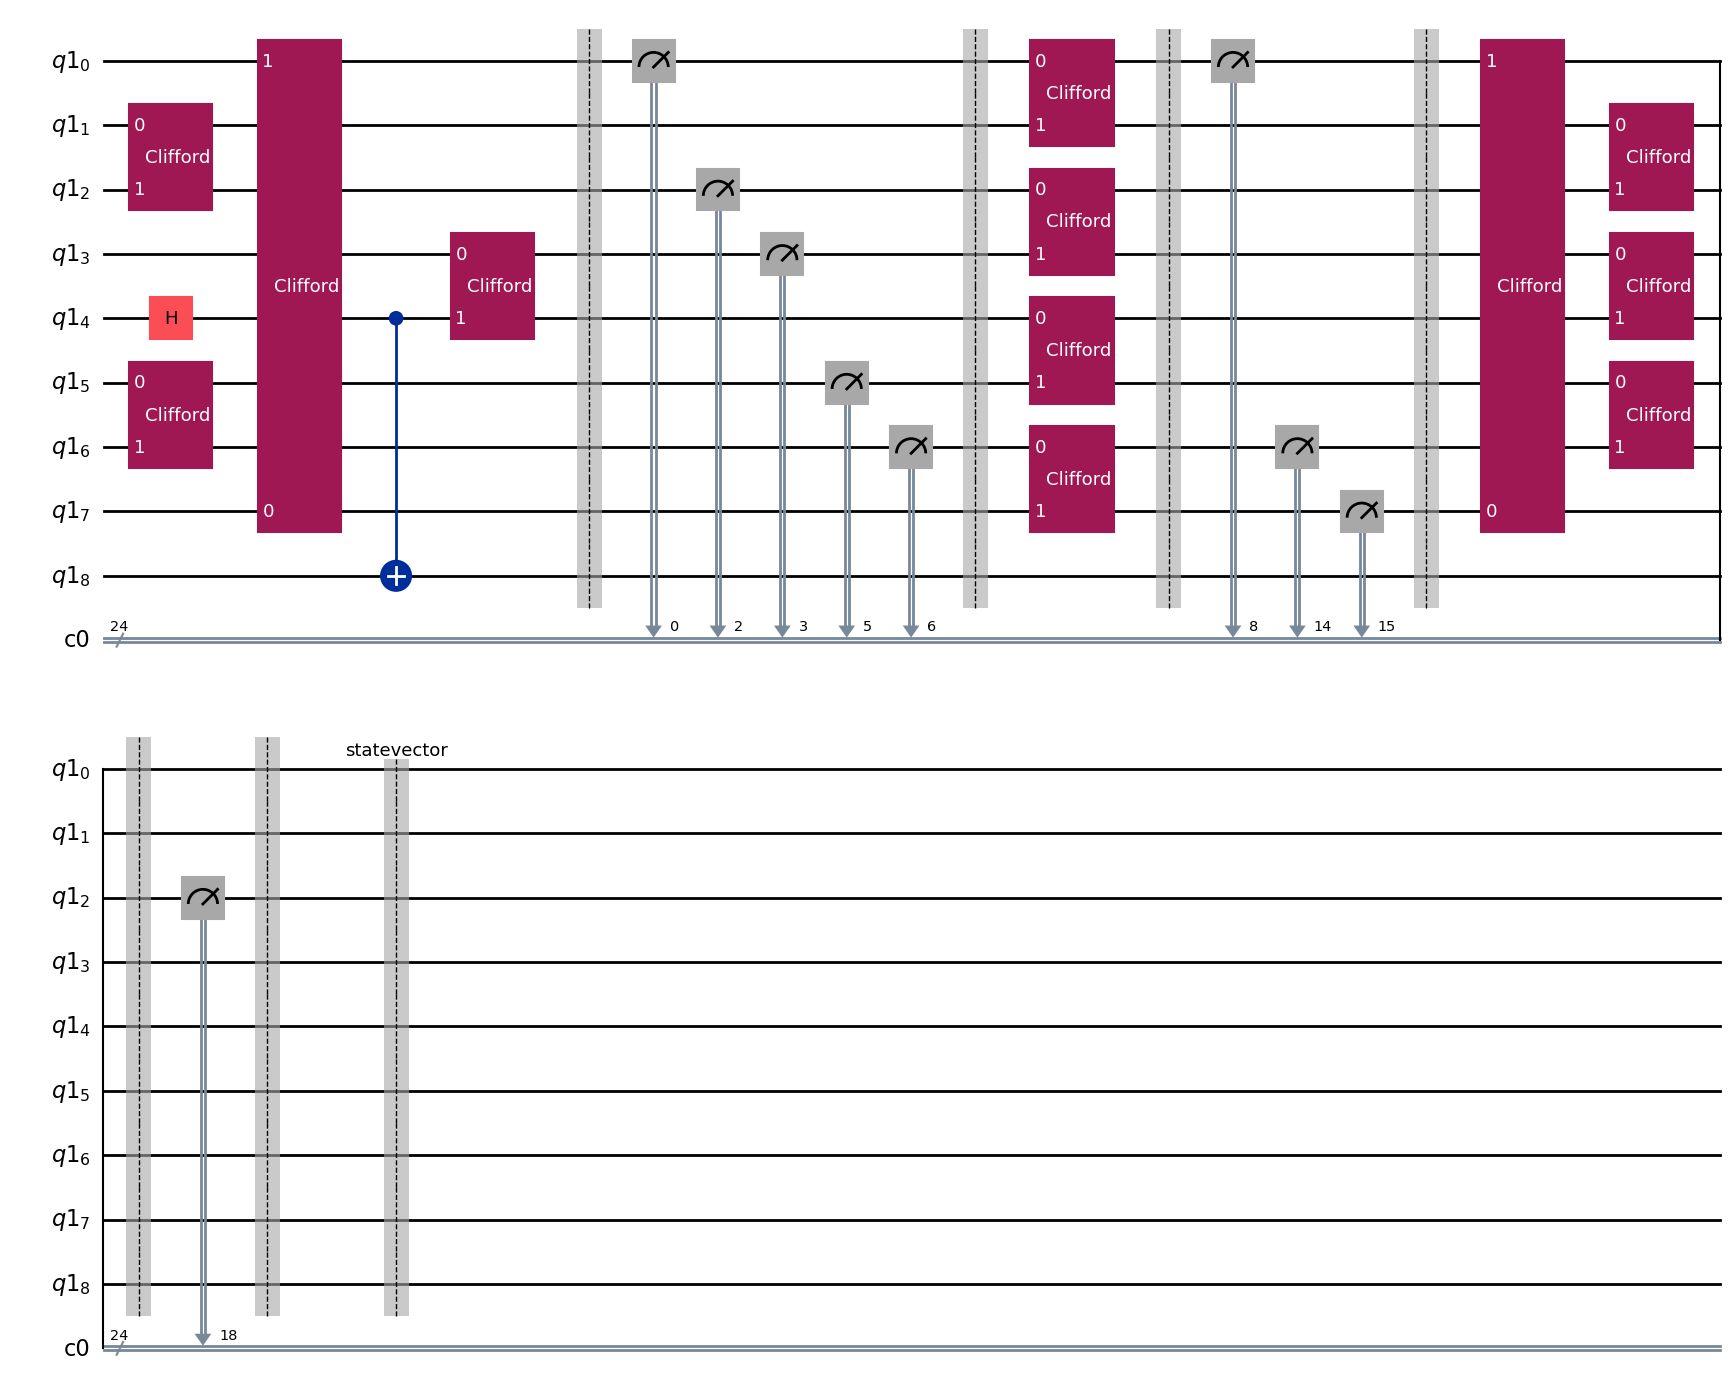

In [3]:
n_qbits = 8
T = 3
qc, meas_mask = rand_Cliff_circ(n_qbits=n_qbits, T=T)
qc.draw("mpl")

In [4]:
n_qbits = 8
T = 1
probs = np.linspace(0, 1, 7)
Ts = np.arange(1, 20)

entang_entropy = np.zeros((probs.shape[0], Ts.shape[0]))

for p_idx, prob in enumerate(probs):
    for T_idx, T in enumerate(Ts):
        print(p_idx, T_idx, prob, T)

        runs = np.arange(0, 100)

        # state_vector = np.zeros((runs.shape[0], 2**(n_qbits+1)), dtype=complex)
        # dens_mat = np.zeros((runs.shape[0], 2**(n_qbits+1), 2**(n_qbits+1)), dtype=complex)
        meas_mat_arr = []
        par_tra_arr = []
        ent_entropy_arr = []

        for i in runs:
            qc, meas_mask = rand_Cliff_circ(n_qbits=n_qbits, T=T, prob=prob)
            result = run_circuit_and_get_results(qc)

            counts = list(result.get_counts().keys())
            meas_arr = np.array(list(list(meas) for meas in counts), dtype=int)
            meas_arr = np.array(meas_arr).reshape(T, n_qbits)
            meas_mat_arr.append(np.ma.masked_array(meas_arr, mask=meas_mask))

            state_vec = result.get_statevector()
            dens_mat = DensityMatrix(state_vec)
            part_trace = partial_trace(dens_mat, range(n_qbits))
            par_tra_arr.append(part_trace.data)
            ent_entropy_arr.append(entropy(part_trace))

        avg_ent_entropy = np.average(ent_entropy_arr)
        print(avg_ent_entropy)

        entang_entropy[p_idx, T_idx] = avg_ent_entropy

0 0 0.0 1
1.224695075375089e-15
0 1 0.0 2
8.080636966897873e-16
0 2 0.0 3
9.419631835862964e-16
0 3 0.0 4
8.319212783693764e-16
0 4 0.0 5
6.833842502010726e-16
0 5 0.0 6
8.720324642745271e-16
0 6 0.0 7
9.057090871295202e-16
0 7 0.0 8
5.366119393626818e-16
0 8 0.0 9


KeyboardInterrupt: 

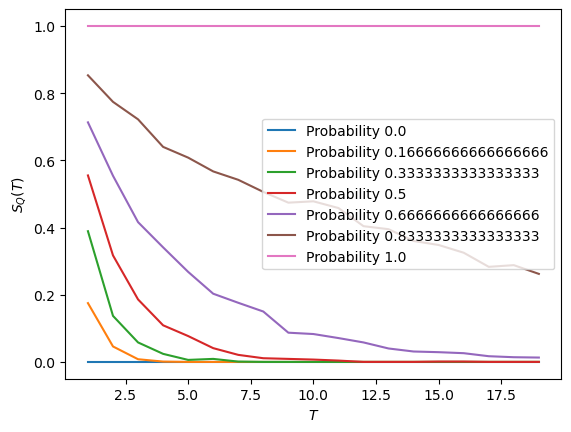

In [26]:
import matplotlib.pyplot as plt

for i in range(entang_entropy.shape[0]):
    plt.plot(Ts, entang_entropy[i], label=f"Probability {probs[i]}")

plt.ylabel(r"$S_Q(T)$")
plt.xlabel(r"$T$")
plt.legend()
